# <center>Qubit demos - working with a real qubit

Here we make the demos to work with a real qubit. This notebook uses the tproc v2 version of the firmware and the zcu216 board.


Imports

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

import json
import datetime

# Quantum machines fitting library for Rabi, Ramsey etc
from qualang_tools.plot import Fit

import pprint as pp

# Used for live plotting, need to run "python -m visdom.server" in the terminal and open the IP address in browser
import visdom

# from plotting_helpers import *
from tqdm import tqdm
from scipy.optimize import curve_fit

2024-10-22 18:46:20,219 - qm - INFO     - Starting session: 3a047235-73b4-4a0e-a391-d689fd13e82d


Connect to RFSoC using Pyro4

In [ ]:
# import Pyro4
# from qick import QickConfig
# Pyro4.config.SERIALIZER = "pickle"
# Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# ns_host = "192.168.1.144"
# ns_port = 8000
# proxy_name = "rfsoc"

# ns = Pyro4.locateNS(host=ns_host, port=ns_port)
# soc = Pyro4.Proxy(ns.lookup(proxy_name))
# soccfg = QickConfig(soc.get_cfg())
# print(soccfg)

### Helper functions

In [2]:
soc = QickSoc(bitfile="../../fw/2024-09-28_216_tprocv2r21_standard/qick_216.bit")
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

resetting clocks: 245.76 491.52
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Sat Sep 28 22:15:40 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (3.419 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 3 is 3_228, on JHC2
	4:	axis_sg_mixmux8_v1 - envelope memory 0 samples (0.000 us)
		fs=68

### Configuring the channels

In [3]:
FSGEN_CH = 0
MIXMUXGEN_CH = 4

MUXRO_CH = [2,3,4,5,6,7]

# TOF Measurement

Measures the "time of flight" of the measurement pulse. The time of flight is the time at which the measurement pulse appears in the ADC buffer. We only want to start capturing data from this point in time onwards. We store this time of flight in the parameter <code> config["trig_time"] </code>.

In [4]:
class MuxProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
config = {'gen_ch': MIXMUXGEN_CH,
          'ro_chs': MUXRO_CH,
          'mixer_freq': 6000,
          'nqz': 2,
          'pulse_freqs': [6191.519, 6216, 6292.321, 6405.85, 6432.959, 6468.441],
          'pulse_gains': [1.0]*6,
          'pulse_phases': [0.0]*6,
          'ro_phases': [0.0]*6,
          'trig_time': 0.0,
          'pulse_len': 0.5,
          'ro_len': 1.0,
         }
print(config)
prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=2000)

{'gen_ch': 4, 'ro_chs': [2, 3, 4, 5, 6, 7], 'mixer_freq': 6000, 'nqz': 2, 'pulse_freqs': [6191.519, 6216, 6292.321, 6405.85, 6432.959, 6468.441], 'pulse_gains': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'pulse_phases': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'ro_phases': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'trig_time': 0.0, 'pulse_len': 0.5, 'ro_len': 1.0}


  0%|          | 0/2000 [00:00<?, ?it/s]

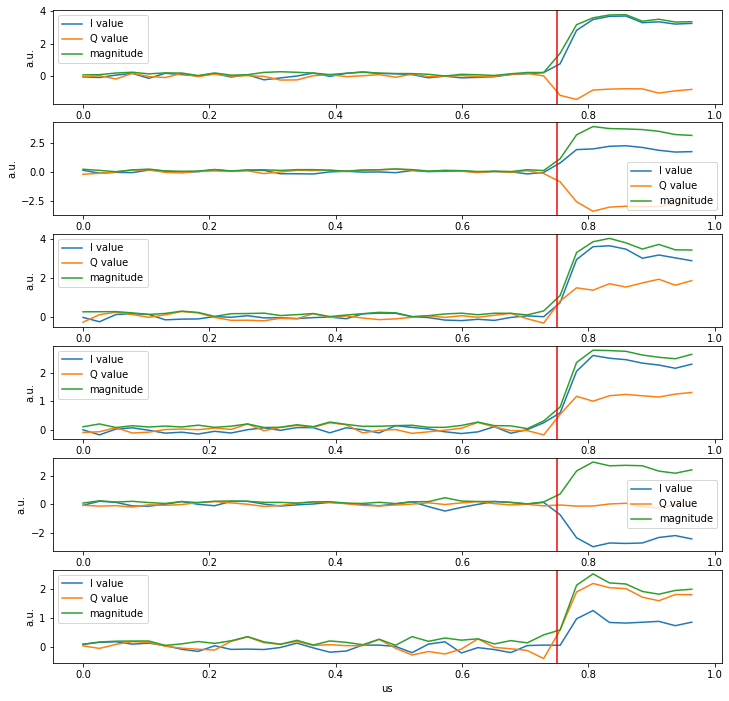

In [5]:
t = prog.get_time_axis(ro_index=0)
fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");
    ######## SET THIS VALUE AS YOUR config['trig_time'] #########
    plot.axvline(0.75, c='r') 

# Single tone (Resonator) Spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state. We store this resonant frequency in the parameter <code> config["f_res"] </code>.

In [6]:
class SingleToneSpectroscopyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['res_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['f_res'], 
                         mux_gains=cfg['res_gain'],
                         mux_phases=cfg['res_phase'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['f_res'], cfg['ro_phase']):
            self.declare_readout(ch=ch, length=cfg['res_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="res_pulse", 
                       style="const", 
                       length=cfg["res_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
    def _body(self, cfg):
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'])
    

In [7]:
# 'pulse_freqs': [6191.519, 6216, 6292.321, 6405.85, 6432.959, 6468.441],
# Since this is MUX readout we can't sweep over frequencies dynamically
# So we will do it in a Python for loop

fcenter = np.array([6191.519, 6216, 6292.321, 6405.85, 6432.959, 6468.441,]) 

In [8]:
import math
#convert power on vna to QICK drive

def convert_dbm_to_qick_power(dbm_list):
    converted_to_qick = []
    for i in dbm_list:
        converted_val = 2 ** (i / 6)      #subtract 6 every time you cut value in half
        converted_val = converted_val*8 
        
        #These are still to low to see anything on the QICK, add a little as a fix for now
        converted_val = converted_val + 0.35
        
        converted_to_qick.append(converted_val)
    return converted_to_qick

inputs = [-42,-36, -24,-18, -12, -6, 0]   
results = convert_dbm_to_qick_power(inputs)
print(results)

res_vna_probe_dbm=[-40, -35, -35, -45, -45, -35]
qubit_vna_pump_dbm=[-40, -40, -35, -30, -35, -40]

res_vna_probe_gain = convert_dbm_to_qick_power(res_vna_probe_dbm)
qubit_vna_pump_gain = convert_dbm_to_qick_power(qubit_vna_pump_dbm)

print('Pump gains: ', qubit_vna_pump_gain)
print('Probe gains: ' , res_vna_probe_gain)

[0.4125, 0.475, 0.85, 1.35, 2.35, 4.35, 8.35]
Pump gains:  [0.4287450656184295, 0.4287450656184295, 0.4903077560386716, 0.6, 0.4903077560386716, 0.4287450656184295]
Probe gains:  [0.4287450656184295, 0.4903077560386716, 0.4903077560386716, 0.3941941738241592, 0.3941941738241592, 0.4903077560386716]


### Plot Resonator Punch Out

In [9]:
#Plot punchout of resonator

expt_cfg={"start":-1.5, "step":0.01, "expts":250, "reps":100, "rounds": 1,}
fpts=expt_cfg["start"] + expt_cfg["step"]*np.arange(expt_cfg["expts"])

config = {
    ## Channel Params. ##
    'res_ch': MIXMUXGEN_CH,
    'ro_chs': MUXRO_CH,
    'nqz': 2,
    ## Resonator Pulse Params. ##
    'mixer_freq': 6000,
    'res_len': 4.0, # [us]
#     'res_gain': [0.3] * 5 + [0.5],
    'res_gain': res_vna_probe_gain, #[1.0] * 5 + [1.0],

    'res_phase': [0.0]*6,
    ## Readout Params. ##
    'ro_phase': [0.0]*6,
    'trig_time': 0.75, # [us]
    'relax_delay': 20, # [us]
     }

power_sweep = np.linspace(0.3, 1, 10) #max is 10, do NOT go above 40.
resonance_vals=[]
frequency_sweeps=[]
for p in power_sweep:
    power=round(p,3)
    config['res_gain'] = [power for i in range(0,6)]
    
    amps=np.zeros((len(fcenter), len(fpts)))
    for index, f in enumerate(tqdm(fpts)):
        config["f_res"]= fcenter + f#array of 4 pulse freq
        prog = SingleToneSpectroscopyProgram(soccfg, reps=expt_cfg["reps"], final_delay=0.5, cfg=config)    
        iq_list = prog.acquire(soc, soft_avgs = expt_cfg["rounds"], progress=False)
        for i in range(len(fcenter)):
            amps[i][index]=np.abs(iq_list[i][:,0]+1j*iq_list[i][:,1])
    amps=np.array(amps)
    frequency_sweeps.append(amps)
    
    freq_res = []
    for i in range(6):
        freq_res.append(round(float(fpts[np.argmin(amps[i])] + fcenter[i]),3))
    resonance_vals.append(freq_res)

  0%|          | 0/250 [00:00<?, ?it/s]The readout at 6404.350 MHz may see some crosstalk from the tone at 6431.459 MHz.
The readout at 6404.360 MHz may see some crosstalk from the tone at 6431.469 MHz.
The readout at 6404.370 MHz may see some crosstalk from the tone at 6431.479 MHz.
  1%|          | 3/250 [00:00<00:09, 26.44it/s]The readout at 6404.380 MHz may see some crosstalk from the tone at 6431.489 MHz.
The readout at 6404.390 MHz may see some crosstalk from the tone at 6431.499 MHz.
The readout at 6404.400 MHz may see some crosstalk from the tone at 6431.509 MHz.
  2%|▏         | 6/250 [00:00<00:09, 26.60it/s]The readout at 6404.410 MHz may see some crosstalk from the tone at 6431.519 MHz.
The readout at 6404.420 MHz may see some crosstalk from the tone at 6431.529 MHz.
The readout at 6404.430 MHz may see some crosstalk from the tone at 6431.539 MHz.
  4%|▎         | 9/250 [00:00<00:09, 26.57it/s]The readout at 6404.440 MHz may see some crosstalk from the tone at 6431.549 MHz.


The readout at 6192.289 MHz may see some crosstalk from the tone at 6216.770 MHz.
 91%|█████████ | 228/250 [00:07<00:00, 26.88it/s]The readout at 6192.299 MHz may see some crosstalk from the tone at 6216.780 MHz.
The readout at 6192.309 MHz may see some crosstalk from the tone at 6216.790 MHz.
The readout at 6192.319 MHz may see some crosstalk from the tone at 6216.800 MHz.
 92%|█████████▏| 231/250 [00:07<00:00, 26.84it/s]The readout at 6192.329 MHz may see some crosstalk from the tone at 6216.810 MHz.
The readout at 6192.339 MHz may see some crosstalk from the tone at 6216.820 MHz.
The readout at 6192.349 MHz may see some crosstalk from the tone at 6216.830 MHz.
 94%|█████████▎| 234/250 [00:08<00:00, 26.79it/s]The readout at 6192.359 MHz may see some crosstalk from the tone at 6216.840 MHz.
The readout at 6192.369 MHz may see some crosstalk from the tone at 6216.850 MHz.
The readout at 6192.379 MHz may see some crosstalk from the tone at 6216.860 MHz.
 95%|█████████▍| 237/250 [00:08<0

 82%|████████▏ | 204/250 [00:06<00:01, 29.51it/s]The readout at 6192.059 MHz may see some crosstalk from the tone at 6216.540 MHz.
The readout at 6192.069 MHz may see some crosstalk from the tone at 6216.550 MHz.
The readout at 6192.079 MHz may see some crosstalk from the tone at 6216.560 MHz.
 83%|████████▎ | 207/250 [00:07<00:01, 28.77it/s]The readout at 6192.089 MHz may see some crosstalk from the tone at 6216.570 MHz.
The readout at 6192.099 MHz may see some crosstalk from the tone at 6216.580 MHz.
The readout at 6192.109 MHz may see some crosstalk from the tone at 6216.590 MHz.
 84%|████████▍ | 210/250 [00:07<00:01, 28.19it/s]The readout at 6192.119 MHz may see some crosstalk from the tone at 6216.600 MHz.
The readout at 6192.129 MHz may see some crosstalk from the tone at 6216.610 MHz.
The readout at 6192.139 MHz may see some crosstalk from the tone at 6216.620 MHz.
 85%|████████▌ | 213/250 [00:07<00:01, 27.10it/s]The readout at 6192.149 MHz may see some crosstalk from the tone a

The readout at 6404.720 MHz may see some crosstalk from the tone at 6431.829 MHz.
The readout at 6404.730 MHz may see some crosstalk from the tone at 6431.839 MHz.
 16%|█▌        | 39/250 [00:01<00:08, 26.20it/s]The readout at 6404.740 MHz may see some crosstalk from the tone at 6431.849 MHz.
The readout at 6404.750 MHz may see some crosstalk from the tone at 6431.859 MHz.
The readout at 6404.760 MHz may see some crosstalk from the tone at 6431.869 MHz.
 17%|█▋        | 42/250 [00:01<00:07, 26.35it/s]The readout at 6404.770 MHz may see some crosstalk from the tone at 6431.879 MHz.
The readout at 6404.780 MHz may see some crosstalk from the tone at 6431.889 MHz.
The readout at 6404.790 MHz may see some crosstalk from the tone at 6431.899 MHz.
 18%|█▊        | 45/250 [00:01<00:07, 26.46it/s]The readout at 6404.800 MHz may see some crosstalk from the tone at 6431.909 MHz.
The readout at 6404.810 MHz may see some crosstalk from the tone at 6431.919 MHz.
The readout at 6404.820 MHz may see 

The readout at 6404.490 MHz may see some crosstalk from the tone at 6431.599 MHz.
  6%|▌         | 15/250 [00:00<00:08, 26.67it/s]The readout at 6404.500 MHz may see some crosstalk from the tone at 6431.609 MHz.
The readout at 6404.510 MHz may see some crosstalk from the tone at 6431.619 MHz.
The readout at 6404.520 MHz may see some crosstalk from the tone at 6431.629 MHz.
  7%|▋         | 18/250 [00:00<00:08, 26.66it/s]The readout at 6404.530 MHz may see some crosstalk from the tone at 6431.639 MHz.
The readout at 6404.540 MHz may see some crosstalk from the tone at 6431.649 MHz.
The readout at 6404.550 MHz may see some crosstalk from the tone at 6431.659 MHz.
  8%|▊         | 21/250 [00:00<00:08, 26.64it/s]The readout at 6404.560 MHz may see some crosstalk from the tone at 6431.669 MHz.
The readout at 6404.570 MHz may see some crosstalk from the tone at 6431.679 MHz.
The readout at 6404.580 MHz may see some crosstalk from the tone at 6431.689 MHz.
 10%|▉         | 24/250 [00:00<00:08

The readout at 6192.429 MHz may see some crosstalk from the tone at 6216.910 MHz.
The readout at 6192.439 MHz may see some crosstalk from the tone at 6216.920 MHz.
 97%|█████████▋| 243/250 [00:08<00:00, 26.53it/s]The readout at 6192.449 MHz may see some crosstalk from the tone at 6216.930 MHz.
The readout at 6192.459 MHz may see some crosstalk from the tone at 6216.940 MHz.
The readout at 6192.469 MHz may see some crosstalk from the tone at 6216.950 MHz.
 98%|█████████▊| 246/250 [00:08<00:00, 26.50it/s]The readout at 6192.479 MHz may see some crosstalk from the tone at 6216.960 MHz.
The readout at 6192.489 MHz may see some crosstalk from the tone at 6216.970 MHz.
The readout at 6192.499 MHz may see some crosstalk from the tone at 6216.980 MHz.
  0%|          | 0/250 [00:00<?, ?it/s]The readout at 6404.350 MHz may see some crosstalk from the tone at 6431.459 MHz.
The readout at 6404.360 MHz may see some crosstalk from the tone at 6431.469 MHz.
The readout at 6404.370 MHz may see some cr

The readout at 6192.199 MHz may see some crosstalk from the tone at 6216.680 MHz.
The readout at 6192.209 MHz may see some crosstalk from the tone at 6216.690 MHz.
 88%|████████▊ | 220/250 [00:07<00:01, 26.48it/s]The readout at 6192.219 MHz may see some crosstalk from the tone at 6216.700 MHz.
The readout at 6192.229 MHz may see some crosstalk from the tone at 6216.710 MHz.
The readout at 6192.239 MHz may see some crosstalk from the tone at 6216.720 MHz.
 89%|████████▉ | 223/250 [00:07<00:01, 26.56it/s]The readout at 6192.249 MHz may see some crosstalk from the tone at 6216.730 MHz.
The readout at 6192.259 MHz may see some crosstalk from the tone at 6216.740 MHz.
The readout at 6192.269 MHz may see some crosstalk from the tone at 6216.750 MHz.
 90%|█████████ | 226/250 [00:07<00:00, 26.61it/s]The readout at 6192.279 MHz may see some crosstalk from the tone at 6216.760 MHz.
The readout at 6192.289 MHz may see some crosstalk from the tone at 6216.770 MHz.
The readout at 6192.299 MHz may s

 20%|██        | 51/250 [00:01<00:07, 26.43it/s]The readout at 6404.860 MHz may see some crosstalk from the tone at 6431.969 MHz.
The readout at 6404.870 MHz may see some crosstalk from the tone at 6431.979 MHz.
The readout at 6404.880 MHz may see some crosstalk from the tone at 6431.989 MHz.
 79%|███████▉  | 197/250 [00:06<00:01, 30.88it/s]The readout at 6192.009 MHz may see some crosstalk from the tone at 6216.490 MHz.
The readout at 6192.019 MHz may see some crosstalk from the tone at 6216.500 MHz.
 80%|████████  | 201/250 [00:06<00:01, 30.31it/s]The readout at 6192.029 MHz may see some crosstalk from the tone at 6216.510 MHz.
The readout at 6192.039 MHz may see some crosstalk from the tone at 6216.520 MHz.
The readout at 6192.049 MHz may see some crosstalk from the tone at 6216.530 MHz.
The readout at 6192.059 MHz may see some crosstalk from the tone at 6216.540 MHz.
 82%|████████▏ | 205/250 [00:06<00:01, 29.24it/s]The readout at 6192.069 MHz may see some crosstalk from the tone at

The readout at 6404.630 MHz may see some crosstalk from the tone at 6431.739 MHz.
The readout at 6404.640 MHz may see some crosstalk from the tone at 6431.749 MHz.
 12%|█▏        | 30/250 [00:01<00:08, 26.53it/s]The readout at 6404.650 MHz may see some crosstalk from the tone at 6431.759 MHz.
The readout at 6404.660 MHz may see some crosstalk from the tone at 6431.769 MHz.
The readout at 6404.670 MHz may see some crosstalk from the tone at 6431.779 MHz.
 13%|█▎        | 33/250 [00:01<00:08, 26.54it/s]The readout at 6404.680 MHz may see some crosstalk from the tone at 6431.789 MHz.
The readout at 6404.690 MHz may see some crosstalk from the tone at 6431.799 MHz.
The readout at 6404.700 MHz may see some crosstalk from the tone at 6431.809 MHz.
 14%|█▍        | 36/250 [00:01<00:08, 26.53it/s]The readout at 6404.710 MHz may see some crosstalk from the tone at 6431.819 MHz.
The readout at 6404.720 MHz may see some crosstalk from the tone at 6431.829 MHz.
The readout at 6404.730 MHz may see 

The readout at 6404.400 MHz may see some crosstalk from the tone at 6431.509 MHz.
  2%|▏         | 6/250 [00:00<00:09, 26.89it/s]The readout at 6404.410 MHz may see some crosstalk from the tone at 6431.519 MHz.
The readout at 6404.420 MHz may see some crosstalk from the tone at 6431.529 MHz.
The readout at 6404.430 MHz may see some crosstalk from the tone at 6431.539 MHz.
  4%|▎         | 9/250 [00:00<00:09, 25.63it/s]The readout at 6404.440 MHz may see some crosstalk from the tone at 6431.549 MHz.
The readout at 6404.450 MHz may see some crosstalk from the tone at 6431.559 MHz.
The readout at 6404.460 MHz may see some crosstalk from the tone at 6431.569 MHz.
  5%|▍         | 12/250 [00:00<00:09, 26.06it/s]The readout at 6404.470 MHz may see some crosstalk from the tone at 6431.579 MHz.
The readout at 6404.480 MHz may see some crosstalk from the tone at 6431.589 MHz.
The readout at 6404.490 MHz may see some crosstalk from the tone at 6431.599 MHz.
  6%|▌         | 15/250 [00:00<00:08, 

 93%|█████████▎| 232/250 [00:08<00:00, 26.37it/s]The readout at 6192.339 MHz may see some crosstalk from the tone at 6216.820 MHz.
The readout at 6192.349 MHz may see some crosstalk from the tone at 6216.830 MHz.
The readout at 6192.359 MHz may see some crosstalk from the tone at 6216.840 MHz.
 94%|█████████▍| 235/250 [00:08<00:00, 26.44it/s]The readout at 6192.369 MHz may see some crosstalk from the tone at 6216.850 MHz.
The readout at 6192.379 MHz may see some crosstalk from the tone at 6216.860 MHz.
The readout at 6192.389 MHz may see some crosstalk from the tone at 6216.870 MHz.
 95%|█████████▌| 238/250 [00:08<00:00, 26.48it/s]The readout at 6192.399 MHz may see some crosstalk from the tone at 6216.880 MHz.
The readout at 6192.409 MHz may see some crosstalk from the tone at 6216.890 MHz.
The readout at 6192.419 MHz may see some crosstalk from the tone at 6216.900 MHz.
 96%|█████████▋| 241/250 [00:08<00:00, 26.50it/s]The readout at 6192.429 MHz may see some crosstalk from the tone a

The readout at 6192.109 MHz may see some crosstalk from the tone at 6216.590 MHz.
The readout at 6192.119 MHz may see some crosstalk from the tone at 6216.600 MHz.
 84%|████████▍ | 211/250 [00:07<00:01, 27.95it/s]The readout at 6192.129 MHz may see some crosstalk from the tone at 6216.610 MHz.
The readout at 6192.139 MHz may see some crosstalk from the tone at 6216.620 MHz.
The readout at 6192.149 MHz may see some crosstalk from the tone at 6216.630 MHz.
 86%|████████▌ | 214/250 [00:07<00:01, 27.59it/s]The readout at 6192.159 MHz may see some crosstalk from the tone at 6216.640 MHz.
The readout at 6192.169 MHz may see some crosstalk from the tone at 6216.650 MHz.
The readout at 6192.179 MHz may see some crosstalk from the tone at 6216.660 MHz.
 87%|████████▋ | 217/250 [00:07<00:01, 27.36it/s]The readout at 6192.189 MHz may see some crosstalk from the tone at 6216.670 MHz.
The readout at 6192.199 MHz may see some crosstalk from the tone at 6216.680 MHz.
The readout at 6192.209 MHz may s

 17%|█▋        | 42/250 [00:01<00:07, 26.64it/s]The readout at 6404.770 MHz may see some crosstalk from the tone at 6431.879 MHz.
The readout at 6404.780 MHz may see some crosstalk from the tone at 6431.889 MHz.
The readout at 6404.790 MHz may see some crosstalk from the tone at 6431.899 MHz.
 18%|█▊        | 45/250 [00:01<00:07, 26.66it/s]The readout at 6404.800 MHz may see some crosstalk from the tone at 6431.909 MHz.
The readout at 6404.810 MHz may see some crosstalk from the tone at 6431.919 MHz.
The readout at 6404.820 MHz may see some crosstalk from the tone at 6431.929 MHz.
 19%|█▉        | 48/250 [00:01<00:07, 25.89it/s]The readout at 6404.830 MHz may see some crosstalk from the tone at 6431.939 MHz.
The readout at 6404.840 MHz may see some crosstalk from the tone at 6431.949 MHz.
The readout at 6404.850 MHz may see some crosstalk from the tone at 6431.959 MHz.
 20%|██        | 51/250 [00:01<00:07, 26.17it/s]The readout at 6404.860 MHz may see some crosstalk from the tone at 64

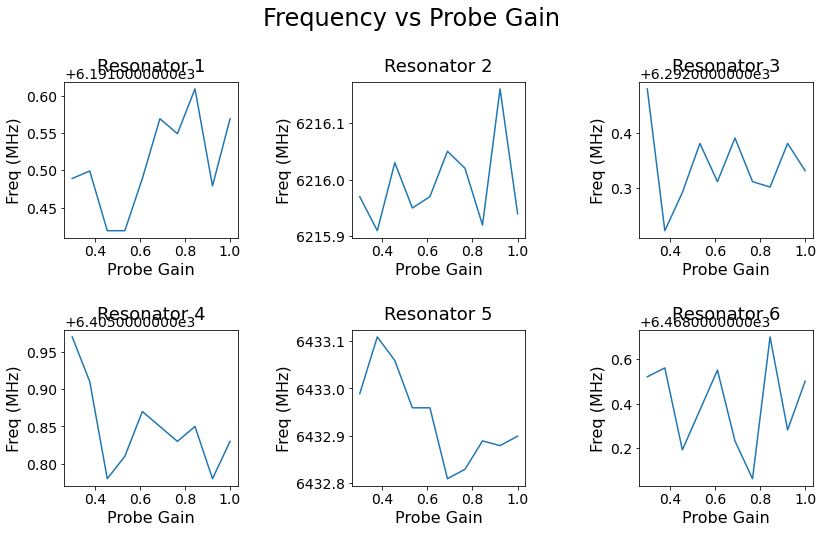

In [10]:
#plot freq Vals
plt.figure(figsize=(12, 8))

# Set larger font sizes
plt.rcParams.update({
    'font.size': 14,  # Base font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 16,  # Axis label font size
    'xtick.labelsize': 14,  # X-axis tick label size
    'ytick.labelsize': 14,  # Y-axis tick label size
    'legend.fontsize': 14,  # Legend font size
})

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(power_sweep, [six_resonance_vals[i] for six_resonance_vals in resonance_vals], '-', linewidth=1.5)
    
    plt.xlabel("Probe Gain", fontweight='normal')
    plt.ylabel("Freq (MHz)", fontweight='normal')
    plt.title(f"Resonator {i + 1}", pad=10)

# Add a main title to the figure
plt.suptitle("Frequency vs Probe Gain", fontsize=24, y=0.95)

plt.tight_layout(pad=2.0)
plt.show()

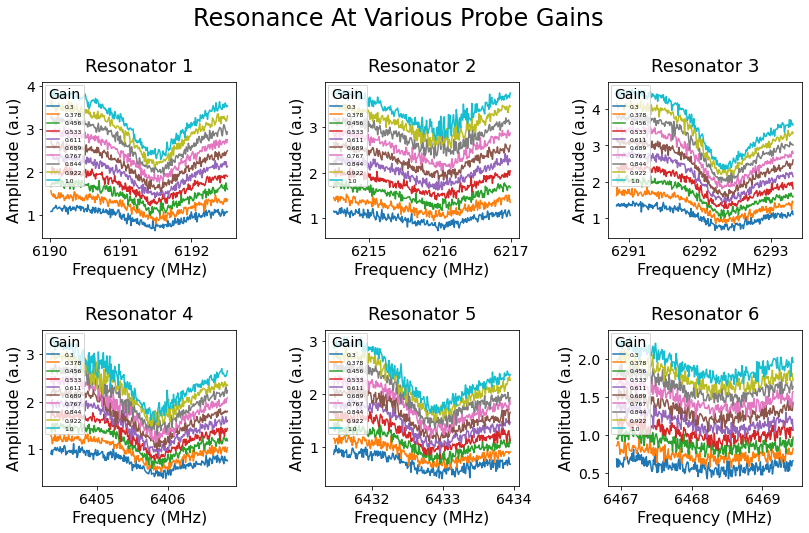

In [11]:
#plot freq sweeps
plt.figure(figsize=(12, 8))

# Set larger font sizes
plt.rcParams.update({
    'font.size': 14,  # Base font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 16,  # Axis label font size
    'xtick.labelsize': 14,  # X-axis tick label size
    'ytick.labelsize': 14,  # Y-axis tick label size
    'legend.fontsize': 14,  # Legend font size
})
for power_index in range(len(power_sweep)):
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.plot(fpts+fcenter[i], frequency_sweeps[power_index][i], '-', linewidth=1.5, label = round(power_sweep[power_index],3))
        
        plt.xlabel("Frequency (MHz)", fontweight='normal')
        plt.ylabel("Amplitude (a.u)", fontweight='normal')
        plt.title(f"Resonator {i + 1}", pad=10)
        plt.legend(loc='upper left', fontsize='6', title = 'Gain')

# Add a main title to the figure
plt.suptitle("Resonance At Various Probe Gains", fontsize=24, y=0.95)


plt.tight_layout(pad=2.0)
plt.show()

### Get Resonance frequencies for a given gain

In [12]:
expt_cfg={"start":-3.5, "step":0.12, "expts":101, "reps":100, "rounds": 1,}
fpts=expt_cfg["start"] + expt_cfg["step"]*np.arange(expt_cfg["expts"])

config = {
    ## Channel Params. ##
    'res_ch': MIXMUXGEN_CH,
    'ro_chs': MUXRO_CH,
    'nqz': 2,
    ## Resonator Pulse Params. ##
    'mixer_freq': 6000,
    'res_len': 4.0, # [us]
#     'res_gain': [0.3] * 5 + [0.5],
    'res_gain': [1.0, 1.0, 0.767, 0.767, 0.767, 1.0], #[1.0] * 5 + [1.0],

    'res_phase': [0.0]*6,
    ## Readout Params. ##
    'ro_phase': [0.0]*6,
    'trig_time': 0.75, # [us]
    'relax_delay': 20, # [us]
     }


amps=np.zeros((len(fcenter), len(fpts)))
for index, f in enumerate(tqdm(fpts)):
    config["f_res"]= fcenter + f#array of 4 pulse freq
    prog = SingleToneSpectroscopyProgram(soccfg, reps=expt_cfg["reps"], final_delay=0.5, cfg=config)    
    iq_list = prog.acquire(soc, soft_avgs = expt_cfg["rounds"], progress=False)
    for i in range(len(fcenter)):
        amps[i][index]=np.abs(iq_list[i][:,0]+1j*iq_list[i][:,1])
amps=np.array(amps)

  9%|▉         | 9/101 [00:01<00:08, 10.80it/s]The readout at 6403.430 MHz may see some crosstalk from the tone at 6430.539 MHz.
The readout at 6403.550 MHz may see some crosstalk from the tone at 6430.659 MHz.
The readout at 6403.670 MHz may see some crosstalk from the tone at 6430.779 MHz.
 12%|█▏        | 12/101 [00:01<00:06, 13.88it/s]The readout at 6403.790 MHz may see some crosstalk from the tone at 6430.899 MHz.
The readout at 6403.910 MHz may see some crosstalk from the tone at 6431.019 MHz.
The readout at 6404.030 MHz may see some crosstalk from the tone at 6431.139 MHz.
 15%|█▍        | 15/101 [00:01<00:05, 16.65it/s]The readout at 6404.150 MHz may see some crosstalk from the tone at 6431.259 MHz.
The readout at 6404.270 MHz may see some crosstalk from the tone at 6431.379 MHz.
The readout at 6404.390 MHz may see some crosstalk from the tone at 6431.499 MHz.
 18%|█▊        | 18/101 [00:01<00:04, 19.02it/s]The readout at 6404.510 MHz may see some crosstalk from the tone at 643

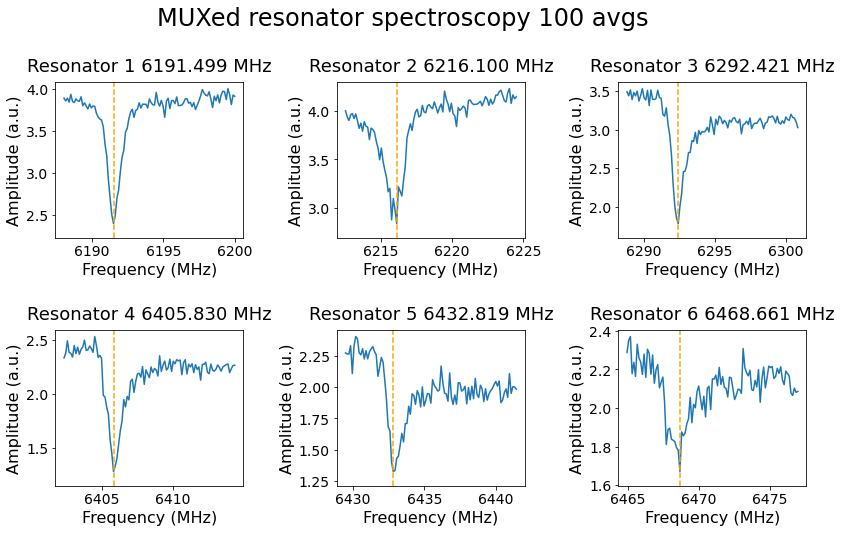

In [13]:
res_freqs = []

# Increase figure size
plt.figure(figsize=(12, 8))

# Set larger font sizes
plt.rcParams.update({
    'font.size': 14,  # Base font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 16,  # Axis label font size
    'xtick.labelsize': 14,  # X-axis tick label size
    'ytick.labelsize': 14,  # Y-axis tick label size
    'legend.fontsize': 14,  # Legend font size
})

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(fpts+fcenter[i], amps[i], '-', linewidth=1.5)
    freq_r = fpts[np.argmin(amps[i])] + fcenter[i]
    res_freqs.append(freq_r)
    plt.axvline(freq_r, linestyle='--', color='orange', linewidth=1.5)
    plt.xlabel("Frequency (MHz)", fontweight='normal')
    plt.ylabel("Amplitude (a.u.)", fontweight='normal')
    plt.title(f"Resonator {i+1} {freq_r:.3f} MHz", pad=10)
    
    # Adjust y-axis limits to show more of the dip
    plt.ylim(plt.ylim()[0] - 0.05 * (plt.ylim()[1] - plt.ylim()[0]), plt.ylim()[1])
    

    
# Add a main title to the figure
plt.suptitle(f"MUXed resonator spectroscopy {expt_cfg['reps']} avgs", fontsize=24, y=0.95)

plt.tight_layout(pad=2.0)

In [14]:
res_gains = config["res_gain"]
res_freqs = [round(x,3) for x in res_freqs]
print("Resonator gains:", res_gains)
print("Resonator freqs:", res_freqs)
#Freqs with the VNA = np.array([6191.519, 6216, 6292.321, 6405.85, 6432.959, 6468.441,]) 

Resonator gains: [1.0, 1.0, 0.767, 0.767, 0.767, 1.0]
Resonator freqs: [6191.499, 6216.1, 6292.421, 6405.83, 6432.819, 6468.661]


In [ ]:
#plt.savefig("6res_50avg.png", dpi=300);

# Choose which qubit you want to measure

In [102]:
# If print(res_gains) does not print all ones, rerun cell 116-120

QubitIndex= 5 #Index 0 means qubit 1

def zero_out_except(lst, index):
  newlist = []
  for i in range(len(lst)):
    if i != index:
      newlist.append(0)
    else:
        newlist.append(lst[i])
  return newlist
    

# Zero the gains of all the resonators besides the one corresponding to the qubit you want to measure

res_gains_QubitIndex = zero_out_except(res_vna_probe_gain, QubitIndex)

print(res_gains_QubitIndex)
print(res_vna_probe_gain)

[0, 0, 0, 0, 0, 0.4903077560386716]
[0.4287450656184295, 0.4903077560386716, 0.4903077560386716, 0.3941941738241592, 0.3941941738241592, 0.4903077560386716]


# Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge. We store this parameter here: <code> exp_config["f_ge"] </code>.

In [103]:
class PulseProbeSpectroscopyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
 
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['f_res'], 
                         mux_gains=cfg['res_gain'],
                         mux_phases=cfg['res_phase'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['f_res'], cfg['ro_phase']):
            self.declare_readout(ch=ch, length=cfg['res_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="res_pulse", 
                       style="const", 
                       length=cfg["res_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
        self.declare_gen(ch=qubit_ch, nqz=1)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_chs[0], 
                       style="const", 
                       length=cfg['pump_len'], 
                       freq=cfg['f_ge'], 
                       phase= 0,
                       gain=cfg['qubit_gain'],
                      )
        
        self.add_loop("freqloop", cfg["steps"])

    
    def _body(self, cfg):
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play probe pulse
        self.delay_auto(t=0.01, tag='waiting') #Wait til qubit pulse is done before proceeding
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'])

In [104]:
from scipy.optimize import curve_fit

def lorentzian(f, f0, gamma, A, B):
    return A * gamma**2 / ((f - f0)**2 + gamma**2) + B

def max_offset_difference_with_x(x_values, y_values, offset):
    max_average_difference = -1
    corresponding_x = None
    
    #average all 3 to avoid noise spikes
    for i in range(len(y_values) - 2):
        #group 3 vals
        y_triplet = y_values[i:i + 3]
        
        #avg differences for these 3 vals
        average_difference = sum(abs(y - offset) for y in y_triplet) / 3
        
        #see if this is the highest difference yet
        if average_difference > max_average_difference:
            max_average_difference = average_difference
            #x value for the middle y value in the 3 vals
            corresponding_x = x_values[i + 1]
            
    return corresponding_x, max_average_difference

def fit_lorenzian(I, Q, freqs, freq_q):
    #guesses
    initial_guess_I = [freq_q, 1, np.max(I), np.min(I)] #x guess (which is very off here), amplitude guess, offset
    initial_guess_Q = [freq_q, 1, np.max(Q), np.min(Q)]

    #fitting the Lorentzian
    params_I, _ = curve_fit(lorentzian, freqs, I, p0=initial_guess_I) 
    params_Q, _ = curve_fit(lorentzian, freqs, Q, p0=initial_guess_Q)

    #print("Offset for I data:", params_I[3])  #B in lorenzian def
    #print("Offset for Q data:", params_Q[3])  #B in lorenzian def

    x_max_diff_I, max_diff_I = max_offset_difference_with_x(freqs, I, params_I[3])
    x_max_diff_Q, max_diff_Q = max_offset_difference_with_x(freqs, Q, params_Q[3])

    #print(f"Max difference for I data: {max_diff_I} at x = {x_max_diff_I}")
    #print(f"Max difference for Q data: {max_diff_Q} at x = {x_max_diff_Q}")


    #guesses
    initial_guess_I = [x_max_diff_I, 1, np.max(I), np.min(I)] #x guess (which is now accurate), amplitude guess, offset
    initial_guess_Q = [x_max_diff_Q, 1, np.max(Q), np.min(Q)]

    #fitting the Lorentzian
    params_I, _ = curve_fit(lorentzian, freqs, I, p0=initial_guess_I)
    params_Q, _ = curve_fit(lorentzian, freqs, Q, p0=initial_guess_Q)

    # make line from the fits
    I_fit = lorentzian(freqs, *params_I)
    Q_fit = lorentzian(freqs, *params_Q)

    mean_I = params_I[0]  # the mean which is from f0 from the fitted parameters for I
    mean_Q = params_Q[0]  # the mean which is from f0 from the fitted parameters for Q
    
    
    #find which fit has the widest curve, becasue data is so noisy im going to assume a thin curve is fitting to a noise peak if there is nothing there
    fwhm_I = 2 * params_I[1]
    fwhm_Q = 2 * params_Q[1]

    # Determine which fit has the widest curve
    if fwhm_I > fwhm_Q:
        widest_fit = "I"
        widest_curve_mean = mean_I
        widest_fwhm = fwhm_I
    else:
        widest_fit = "Q"
        widest_curve_mean = mean_Q
        widest_fwhm = fwhm_Q

    # Print the FWHM for the fit with the widest curve
    print(f"The widest FWHM is for the {widest_fit} data: {widest_fwhm}")


    return mean_I, mean_Q, I_fit, Q_fit, widest_curve_mean, widest_fwhm


In [105]:
# VNA_qubit = np.array([4156.11, 3811.09, 4134.99, 4389.83, 4440.34, 4970.2,]) Initial values found 10/15
VNA_qubit = np.array([4184.11,3816.39, 4143, 4455.94, 4469.94, 4988.22]) # Better found 10/18

# Last 3 qubits might be trickier because close to fsample/2 = 9.58/2 4.79

SPAN = 60
START_FREQ = list(VNA_qubit-SPAN/2) # [MHz]
STOP_FREQ = list(VNA_qubit+SPAN/2) # [MHz]
STEPS = 300

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points
    'reps': 3000,
    
    ## Channel Params. ##
    'res_ch': MIXMUXGEN_CH,
    'ro_chs': MUXRO_CH,
    'qubit_ch': FSGEN_CH,
    
    ## Resonator Pulse Params. ##
    'f_res': res_freqs, #[MHz]
    'nqz': 2,
    'mixer_freq': 6000,
    'res_len': 4.0, # [us]
#     'res_gain': [0,0,0.2,0,0,0],
    'res_gain': res_gains_QubitIndex,    #probe

#     'res_gain': [0,0,0.5,0,0,0],

    'res_phase': [0.0]*6,
    
    ## Readout Params. ##
    'ro_phase': [0.0]*6,
    'trig_time': 0.75, # [us]
    'relax_delay': 300, # [us]
    
    ## Qubit Params. ##
    'f_ge': QickSweep1D('freqloop', START_FREQ[QubitIndex], STOP_FREQ[QubitIndex]), # [MHz]
    "pump_len": 15,# [us]
    "qubit_gain": qubit_vna_pump_gain[QubitIndex], #0.025 Q1 # [DAC units]  #pump
     }

print(config)

qspec=PulseProbeSpectroscopyProgram(soccfg, reps=config['reps'], final_delay= 0.5, cfg=config)

iq_list = qspec.acquire(soc, soft_avgs=1, progress=True)
freqs = qspec.get_pulse_param('qubit_pulse', "freq", as_array=True)

{'steps': 300, 'reps': 3000, 'res_ch': 4, 'ro_chs': [2, 3, 4, 5, 6, 7], 'qubit_ch': 0, 'f_res': [6191.499, 6216.1, 6292.421, 6405.83, 6432.819, 6468.661], 'nqz': 2, 'mixer_freq': 6000, 'res_len': 4.0, 'res_gain': [0, 0, 0, 0, 0, 0.4903077560386716], 'res_phase': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'ro_phase': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'trig_time': 0.75, 'relax_delay': 300, 'f_ge': <qick.asm_v2.QickParam object at 0xffff6a270910>, 'pump_len': 15, 'qubit_gain': 0.4287450656184295}


  0%|          | 0/900000 [00:00<?, ?it/s]

The widest FWHM is for the Q data: 3.190771617564607


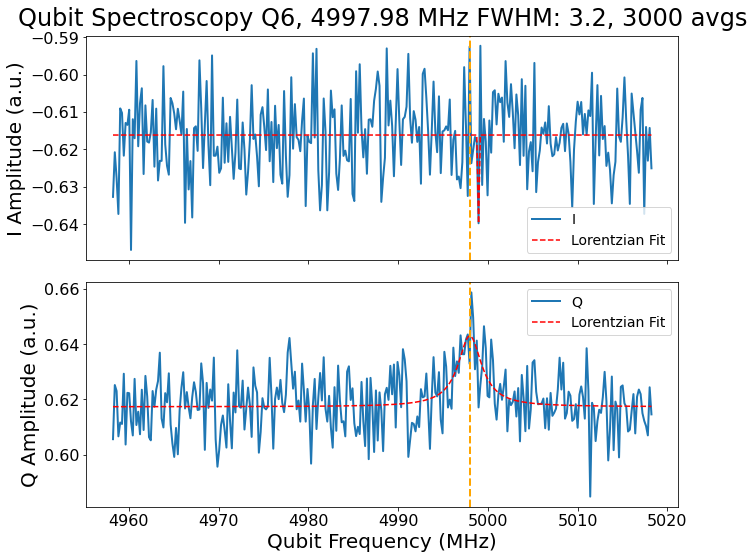

In [106]:
# Prepare your data
I = iq_list[QubitIndex][0, :, 0]
Q = iq_list[QubitIndex][0, :, 1]
freq_q = freqs[np.argmax(I)] 
freqs = np.array(freqs)

mean_I, mean_Q, I_fit, Q_fit, widest_curve_mean,widest_fwhm = fit_lorenzian(I, Q, freqs, freq_q)

# Plot the data and fits
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.rcParams.update({'font.size': 18}) 

# I subplot
ax1.plot(freqs, I, label='I', linewidth=2)
ax1.plot(freqs, I_fit, 'r--', label='Lorentzian Fit')
ax1.set_ylabel("I Amplitude (a.u.)", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.axvline(widest_curve_mean, color='orange', linestyle='--', linewidth=2)
ax1.legend()

# Q subplot
ax2.plot(freqs, Q, label='Q', linewidth=2)
ax2.plot(freqs, Q_fit, 'r--', label='Lorentzian Fit')
ax2.set_xlabel("Qubit Frequency (MHz)", fontsize=20)
ax2.set_ylabel("Q Amplitude (a.u.)", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.axvline(widest_curve_mean, color='orange', linestyle='--', linewidth=2)
ax2.legend()

# Adjust spacing
plt.tight_layout()

# Calculate the middle of the plot area
plot_middle = (ax1.get_position().x0 + ax1.get_position().x1) / 2

# Add title, centered on the plot area
fig.text(plot_middle, 0.98, f"Qubit Spectroscopy Q{QubitIndex+1}, %.2f MHz" %widest_curve_mean + f" FWHM: {round(widest_fwhm,1)}" + f", {config['reps']} avgs", fontsize=24, ha='center', va='top')

# Adjust the top margin to make room for the title
plt.subplots_adjust(top=0.93)

fig.savefig(f"plots/qubit_spec/spec_q{QubitIndex+1}.png", dpi=300, bbox_inches='tight') #, facecolor='white'

## Sweep Power for Resonator (probe) and Qubit (pump) Automatically

### Dont run until QICK crash reason is figured out (change cells from 'markdown' to 'code' to run)

def plot_spec(freqs, I, Q, q_gain, r_gain):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    plt.rcParams.update({'font.size': 18})  # Set base font size

    I = iq_list[5][0, :, 0]
    Q = iq_list[5][0, :, 1]

    freq_q = freqs[np.argmin(I)]

    ax1.plot(freqs, I, label="I", linewidth=2)
    ax1.set_ylabel("I Amplitude (a.u.)", fontsize=20)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.axvline(freq_q, color='orange', linestyle='--', linewidth=2)

    ax2.plot(freqs, Q, label="Q", linewidth=2)
    ax2.set_xlabel("Qubit Frequency (MHz)", fontsize=20)
    ax2.set_ylabel("Q Amplitude (a.u.)", fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.axvline(freq_q, color='orange', linestyle='--', linewidth=2)

    plt.tight_layout()

    plot_middle = (ax1.get_position().x0 + ax1.get_position().x1) / 2

    fig.text(plot_middle, 0.98, f"Qubit Spectroscopy Q{QubitIndex+1}, %.2f MHz" %freq_q + f", {config['reps']} avgs" + ' Qubit Gain: '+  str(q_gain) + ' Resonator Gain: '+  str(r_gain), fontsize=14, ha='center', va='top')

    plt.subplots_adjust(top=0.93)


VNA_qubit = np.array([4184.11, 3816.39 , 4143, 4455.94, 4469.94, 4988.22,]) # Better found 10/18

SPAN = 60
START_FREQ = list(VNA_qubit-SPAN/2) # [MHz]
STOP_FREQ = list(VNA_qubit+SPAN/2) # [MHz]
STEPS = 500

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points
    'reps': 2000,
    
    ## Channel Params. ##
    'res_ch': MIXMUXGEN_CH,
    'ro_chs': MUXRO_CH,
    'qubit_ch': FSGEN_CH,
    
    ## Resonator Pulse Params. ##
    'f_res': res_freqs, # [MHz]
    'nqz': 2,
    'mixer_freq': 6000,
    'res_len': 4.0, # [us]
    'res_gain': res_gains_QubitIndex,

    'res_phase': [0.0]*6,
    
    ## Readout Params. ##
    'ro_phase': [0.0]*6,
    'trig_time': 0.75, # [us]
    'relax_delay': 300, # [us]
    
    ## Qubit Params. ##
    'f_ge': QickSweep1D('freqloop', START_FREQ[QubitIndex], STOP_FREQ[QubitIndex]), # [MHz]
    "pump_len": 15,# [us]
    "qubit_gain": 0.8, #0.025 Q1 # [DAC units]
     }

q_gain_list = np.linspace(0.05, 0.4, 3)
r_gain_list =  np.linspace(0.5, 1, 3)

decimal_places = 5
for r_gain in r_gain_list:
    res_gains_QubitIndex[QubitIndex] = round(r_gain, decimal_places)
    
    for q_gain in q_gain_list:
        config['qubit_gain'] = round(q_gain, decimal_places)
        config['res_gain'] = res_gains_QubitIndex
        
        qspec=PulseProbeSpectroscopyProgram(soccfg, reps=config['reps'], final_delay= 0.5, cfg=config)

        iq_list = qspec.acquire(soc, soft_avgs=1, progress=True)
        freqs = qspec.get_pulse_param('qubit_pulse', "freq", as_array=True)

        plot_spec(freqs, I, Q, round(q_gain, decimal_places), round(r_gain, decimal_places))

# Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is an $\approx$ 100 ns ($\sigma$ $\approx$ 25 ns) long Gaussian pulse. We measure the $\pi$ and $\pi$/2 pulse amplitudes which are used in subsequent experiments to control the qubit. We store these parameters here: <code> config["pi_gain"] </code> and <code> config["pi2_gain"] </code>

In [107]:
class AmplitudeRabiProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
 
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['f_res'], 
                         mux_gains=cfg['res_gain'],
                         mux_phases=cfg['res_phase'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['f_res'], cfg['ro_phase']):
            self.declare_readout(ch=ch, length=cfg['res_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="res_pulse", 
                       style="const", 
                       length=cfg["res_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
        self.declare_gen(ch=qubit_ch, nqz=1)
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['qubit_gain'], 
                      )
        
        self.add_loop("gainloop", cfg["steps"])
    
    def _body(self, cfg):
        self.pulse(ch=cfg["qubit_ch"], name="qubit_pulse", t=0) 
         
        self.delay_auto(t=0.01, tag='waiting') #Wait til qubit pulse is done before proceeding

        self.pulse(ch=cfg['res_ch'], name="res_pulse", t = 0)
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'])
        # relax delay ...


In [108]:
#qubit_gains = [0.80, 0, 0, 0, 0, 0]

#qubit_gains = zero_out_except(qubit_vna_pump_dbm, QubitIndex)

qubit_sigmas = [0.08, 0.15, 0.1, 0.08, 0.12, 0.13]
qubit_sigmas = zero_out_except(qubit_sigmas, QubitIndex)
qubit_gains = [0.80, 0.76, 0.89, 0.8, 0.8, 1]
qubit_gains = zero_out_except(qubit_gains, QubitIndex)

print("Qubit gains:", qubit_gains)
print("Qubit sigmas:", qubit_sigmas)

Qubit gains: [0, 0, 0, 0, 0, 1]
Qubit sigmas: [0, 0, 0, 0, 0, 0.13]


In [109]:
START_GAIN = 0.0 # [DAC units]
STOP_GAIN = 1.0 # [DAC units]
STEPS = 100

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points
    'reps': 3000,
    ## Channel Params. ##
    'res_ch': MIXMUXGEN_CH,
    'ro_chs': MUXRO_CH,
    'qubit_ch': FSGEN_CH,
    
    ## Resonator Pulse Params. ##
    'f_res': res_freqs, # [MHz]
    'nqz': 2,
    'mixer_freq': 6000,
    'res_len': 4.0, # [us]
#     'res_gain': res_gains,
    'res_gain': res_gains_QubitIndex,
#     'res_gain': [1.0]*6,

    'res_phase': [0.0]*6,
    
    ## Readout Params. ##
    'ro_phase': [0.0]*6,
    'trig_time': 0.75, # [us]
    'relax_delay': 300, # [us]
    
        ## Qubit Params. ##
    'f_ge': widest_curve_mean, #qubit_freqs[QubitIndex], # [MHz]
    'qubit_phase': 0, # [deg]
    "qubit_gain":QickSweep1D('gainloop', START_GAIN, STOP_GAIN), # [DAC units]
    'sigma': qubit_sigmas[QubitIndex], # [us]
     }

print(config)
amp_rabi=AmplitudeRabiProgram(soccfg, reps=config['reps'], final_delay=config['relax_delay'], cfg=config)

iq_list = amp_rabi.acquire(soc, soft_avgs=1, progress=True)
gains = amp_rabi.get_pulse_param('qubit_pulse', "gain", as_array=True)

#

{'steps': 100, 'reps': 3000, 'res_ch': 4, 'ro_chs': [2, 3, 4, 5, 6, 7], 'qubit_ch': 0, 'f_res': [6191.499, 6216.1, 6292.421, 6405.83, 6432.819, 6468.661], 'nqz': 2, 'mixer_freq': 6000, 'res_len': 4.0, 'res_gain': [0, 0, 0, 0, 0, 0.4903077560386716], 'res_phase': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'ro_phase': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'trig_time': 0.75, 'relax_delay': 300, 'f_ge': 4997.9810940584, 'qubit_phase': 0, 'qubit_gain': <qick.asm_v2.QickParam object at 0xffff6bbe75b0>, 'sigma': 0.13}


  0%|          | 0/300000 [00:00<?, ?it/s]

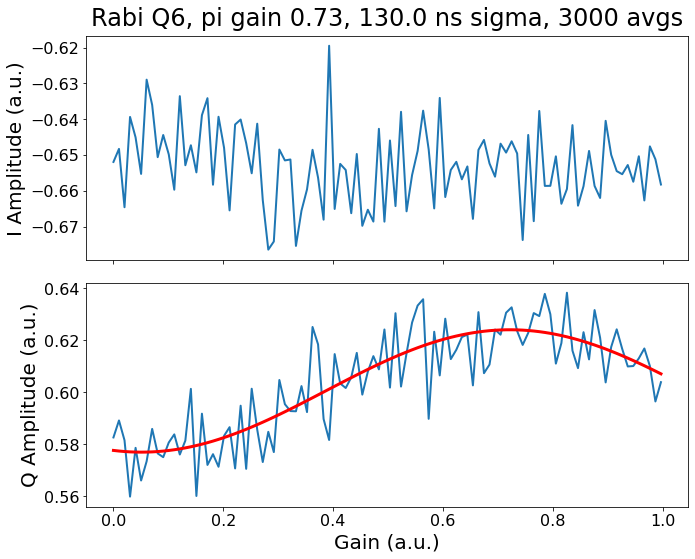

In [110]:
def cosine(x, a, b, c, d):
    return a * np.cos(2. * np.pi * b * x - c * 2 * np.pi) + d

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.rcParams.update({'font.size': 18})  # Set base font size

I = iq_list[QubitIndex][0, :, 0]
Q = iq_list[QubitIndex][0, :, 1]

## Fit 
q1_amp = Q
q1_a_guess = (np.max(q1_amp) - np.min(q1_amp)) / 2
q1_b_guess = 1/gains[-1]
q1_c_guess = 0
q1_d_guess = np.mean(q1_amp)

q1_guess=[q1_a_guess, q1_b_guess, q1_c_guess, q1_d_guess]
q1_popt, q1_pcov = curve_fit(cosine, gains, q1_amp, maxfev = 100000, p0 = q1_guess)
q1_fit_cosine = cosine(gains, *q1_popt)

#figure out whether to use argmax or argmin based on height of first and last values
first_three_avg = np.mean(q1_fit_cosine[:3])
last_three_avg = np.mean(q1_fit_cosine[-3:])

if last_three_avg > first_three_avg:
    pi_amp = gains[np.argmax(q1_fit_cosine)]
else:
    pi_amp = gains[np.argmin(q1_fit_cosine)]
    
#pi_amp = gains[np.argmax(q1_fit_cosine)] #change to argmax/min depending on shape of curve

# I subplot
ax1.plot(gains, I, label="Gain (a.u.)", linewidth=2)
ax1.set_ylabel("I Amplitude (a.u.)", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)
# ax1.axvline(freq_q, color='orange', linestyle='--', linewidth=2)

# Q subplot
ax2.plot(gains, Q, label="Q", linewidth=2)
ax2.set_xlabel("Gain (a.u.)", fontsize=20)
ax2.plot(gains, q1_fit_cosine, '-', color='red', linewidth=3, label="Fit")
ax2.set_ylabel("Q Amplitude (a.u.)", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)
# ax2.axvline(freq_q, color='orange', linestyle='--', linewidth=2)

# Adjust spacing
plt.tight_layout()

# Calculate the middle of the plot area
plot_middle = (ax1.get_position().x0 + ax1.get_position().x1) / 2

# Add title, centered on the plot area
fig.text(plot_middle, 0.98, f"Rabi Q{QubitIndex+1}, pi gain %.2f" %pi_amp + f", {config['sigma']*1000} ns sigma" + f", {config['reps']} avgs", fontsize=24, ha='center', va='top')

# Adjust the top margin to make room for the title
plt.subplots_adjust(top=0.93)

#make sure amplitude matches spec
#probing with higher gain makes rabi easier to see and optimizes snr
#see where punchout happems and try to use max power
#move all of singal into I to help with fitting (instructions in run doc)

fig.savefig(f"plots/rabi/rabi_q{QubitIndex+1}.png", dpi=300, bbox_inches='tight') #, facecolor='white'

# T1 

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [111]:
class T1Program(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
 
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['f_res'], 
                         mux_gains=cfg['res_gain'],
                         mux_phases=cfg['res_phase'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['f_res'], cfg['ro_phase']):
            self.declare_readout(ch=ch, length=cfg['res_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="res_pulse", 
                       style="const", 
                       length=cfg["res_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
        
        self.declare_gen(ch=qubit_ch, nqz=1)
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_chs[0], 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi_gain'], 
                      )
        
        self.add_loop("waitloop", cfg["steps"])        

    def _body(self, cfg):
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play pulse
        
        self.delay_auto(cfg['wait_time']+0.01, tag='wait') # wait_time after last pulse

        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'])
        # relax delay ...        

In [112]:
START_TIME = 0.0 # [us]
STOP_TIME = 100.0 # [us]
STEPS = 50

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points
    'reps': 3000,

    ## Channel Params. ##
    'res_ch': MIXMUXGEN_CH,
    'ro_chs': MUXRO_CH,
    'qubit_ch': FSGEN_CH,
    
    ## Resonator Pulse Params. ##
    'f_res': res_freqs, # [MHz]
    'nqz': 2,
    'mixer_freq': 6000,
    'res_len': 4.0, # [us]
    'res_gain': res_gains_QubitIndex,
    'res_phase': [0.0]*6,
    
    ## Readout Params. ##
    'ro_phase': [0.0]*6,
    'trig_time': 0.75, # [us]
    'relax_delay': 300, # [us]
    'wait_time': QickSweep1D('waitloop', START_TIME, STOP_TIME), # [us]

    ## Qubit Params. ##
    'f_ge': widest_curve_mean, #qubit_freqs[QubitIndex], # [MHz]
    "pi_gain": 0.8, # [DAC units]   I think this should correspond to what you see on rabi
    "pi2_gain": 0.8 / 2, # [DAC units]
    'qubit_phase': 0,
    'sigma': qubit_sigmas[QubitIndex],
     }

print(config)
t1=T1Program(soccfg, reps=config['reps'], final_delay=config['relax_delay'], cfg=config)

iq_list = t1.acquire(soc, soft_avgs=1, progress=True)
delay_times = t1.get_time_param('wait', "t", as_array=True)

{'steps': 50, 'reps': 3000, 'res_ch': 4, 'ro_chs': [2, 3, 4, 5, 6, 7], 'qubit_ch': 0, 'f_res': [6191.499, 6216.1, 6292.421, 6405.83, 6432.819, 6468.661], 'nqz': 2, 'mixer_freq': 6000, 'res_len': 4.0, 'res_gain': [0, 0, 0, 0, 0, 0.4903077560386716], 'res_phase': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'ro_phase': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'trig_time': 0.75, 'relax_delay': 300, 'wait_time': <qick.asm_v2.QickParam object at 0xffff6bf1ada0>, 'f_ge': 4997.9810940584, 'pi_gain': 0.8, 'pi2_gain': 0.4, 'qubit_phase': 0, 'sigma': 0.13}


  0%|          | 0/150000 [00:00<?, ?it/s]

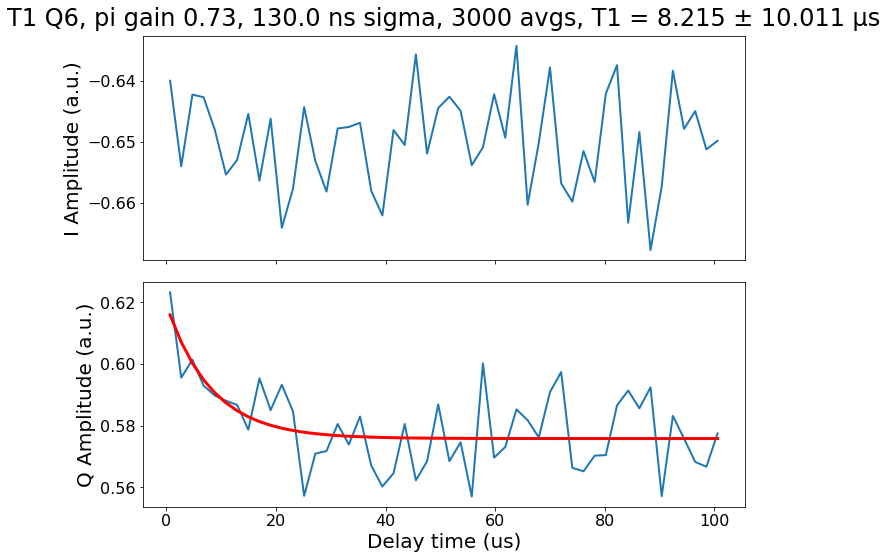

In [114]:
def exponential(x, a, b, c, d):
    return a * np.exp(- (x - b) / c) + d

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.rcParams.update({'font.size': 18})  # Set base font size

I = iq_list[QubitIndex][0, :, 0]
Q = iq_list[QubitIndex][0, :, 1]

# ## Fit 
#q1_a_guess = np.max(Q)-np.min(Q)   #change to np.max(Q)-np.min(Q) depending on direction

#figure out which way the curve is oriented based on the averages of first and last 3 points
signal = Q
average_first_three = np.mean(signal[:3])
average_last_three = np.mean(signal[-3:])

if average_first_three > average_last_three:
    q1_a_guess = np.max(signal) - np.min(signal)
else:
    q1_a_guess = np.min(signal) - np.max(signal)
    
q1_b_guess = 0
q1_c_guess = delay_times[-1]/7 #if not fitting change /6 or /5
q1_d_guess = np.min(signal)

q1_guess =[q1_a_guess, q1_b_guess, q1_c_guess, q1_d_guess]
q1_popt, q1_pcov = curve_fit(exponential, delay_times, signal, maxfev = 100000, p0 = q1_guess)
q1_fit_exponential = exponential(delay_times, *q1_popt)

# I subplot
ax1.plot(delay_times, I, label="Gain (a.u.)", linewidth=2)
ax1.set_ylabel("I Amplitude (a.u.)", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)
# ax1.axvline(freq_q, color='orange', linestyle='--', linewidth=2)

# Q subplot
ax2.plot(delay_times, Q, label="Q", linewidth=2)
ax2.set_xlabel("Delay time (us)", fontsize=20)
ax2.plot(delay_times, q1_fit_exponential, '-', color='red', linewidth=3, label="Fit")
ax2.set_ylabel("Q Amplitude (a.u.)", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)
# ax2.axvline(freq_q, color='orange', linestyle='--', linewidth=2)

# Adjust spacing
plt.tight_layout()

# Calculate the middle of the plot area
plot_middle = (ax1.get_position().x0 + ax1.get_position().x1) / 2

# Add title, centered on the plot area
fig.text(plot_middle, 0.98, f"T1 Q{QubitIndex+1}, pi gain %.2f" %pi_amp + f", {config['sigma']*1000} ns sigma" + f", {config['reps']} avgs," + f" T1 = {q1_popt[2]:.3f} ± {q1_pcov[2][2]:.3f} µs", fontsize=24, ha='center', va='top')

# Adjust the top margin to make room for the title
plt.subplots_adjust(top=0.93)

fig.savefig(f"plots/t1/t1_q{QubitIndex+1}.png", dpi=300, bbox_inches='tight') #, facecolor='white'

# 150 T1 samples histogramed

## Dont run until QICK crashing is fixed

In [ ]:
t1s = []
uncertainties = []
for sample in range(0,150):
    print(stop Error)
    t1=T1Program(soccfg, reps=config['reps'], final_delay=config['relax_delay'], cfg=config)
    iq_list = t1.acquire(soc, soft_avgs=1, progress=True)
    delay_times = t1.get_time_param('wait', "t", as_array=True)
    
    t1s.append(round(q1_popt[2],3))
    uncertainties.append(round(q1_pcov[2][2],3))  
    

In [ ]:
plt.hist(t1, bins='auto', alpha=0.7, color='blue', edgecolor='black')

plt.title('Histogram of T1 Values')
plt.xlabel('T1 (µs)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times (in the below demo we take 5000 shots) and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). We store these two parameters here <code> config["res_phase"] </code> and <code> config["threshold"] </code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. It is placed towards the top of this demo notebook because every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [ ]:
# Both g and e during the same experiment.
class SingleShotProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
 
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['f_res'], 
                         mux_gains=cfg['res_gain'],
                         mux_phases=cfg['res_phase'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['f_res'], cfg['ro_phase']):
            self.declare_readout(ch=ch, length=cfg['res_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="res_pulse", 
                       style="const", 
                       length=cfg["res_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
        
        self.declare_gen(ch=qubit_ch, nqz=1)

        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_chs[0], 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi_gain'], 
                      )
        
#         self.add_loop("shotloop", cfg["steps"]) # number of total shots
        self.add_loop("gainloop", cfg["expts"]) # Pulse / no Pulse loop


    def _body(self, cfg):
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play pulse
        self.delay_auto(0.01)
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'])
        # relax delay ... 
        

In [ ]:

# Separate g and e per each experiment defined.

class SingleShotProgram_g(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
 
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['f_res'], 
                         mux_gains=cfg['res_gain'],
                         mux_phases=cfg['res_phase'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['f_res'], cfg['ro_phase']):
            self.declare_readout(ch=ch, length=cfg['res_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="res_pulse", 
                       style="const", 
                       length=cfg["res_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
        
        self.declare_gen(ch=qubit_ch, nqz=1)

        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_chs[0], 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi_gain'], 
                      )
        
        self.add_loop("shotloop", cfg["steps"]) # number of total shots

    def _body(self, cfg):
        self.delay_auto(0.01)
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'])
        # relax delay ... 
        

class SingleShotProgram_e(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
 
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['f_res'], 
                         mux_gains=cfg['res_gain'],
                         mux_phases=cfg['res_phase'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['f_res'], cfg['ro_phase']):
            self.declare_readout(ch=ch, length=cfg['res_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="res_pulse", 
                       style="const", 
                       length=cfg["res_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
        
        self.declare_gen(ch=qubit_ch, nqz=1)

        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_chs[0], 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi_gain'], 
                      )
        
        self.add_loop("shotloop", cfg["steps"]) # number of total shots


    def _body(self, cfg):
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play pulse
        self.delay_auto(0.01)
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'])
        # relax delay ... 

In [ ]:
SHOTS = 3000

config = {
    ## Sweep Params: ##
    'steps': SHOTS, # Number of shot points (outer loop)
    'expts': 2, # one OFF one ON (inner loop)

    ## Channel Params. ##
    'res_ch': MIXMUXGEN_CH,
    'ro_chs': MUXRO_CH,
    'qubit_ch': FSGEN_CH,
    
    ## Resonator Pulse Params. ##
    'f_res': res_freqs, # [MHz]
    'nqz': 2,
    'mixer_freq': 6000,
    'res_len': 4.0, # [us]
    'res_gain': [1.0] + 5*[0],
    'res_phase': [0.0]*6,

    ## Readout Params. ##
    'ro_phase': [0.0]*6,
    'trig_time': 0.75, # [us]
    'relax_delay': 300, # [us]

    ## Qubit Params. ##
    'f_ge': qubit_freqs[QubitIndex], # [MHz]
    "pi_gain": qubit_gains[QubitIndex], # [DAC units]
    'qubit_phase': 0,
    'sigma': qubit_sigmas[QubitIndex],
     }

ssp_g = SingleShotProgram_g(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
iq_list_g = ssp_g.acquire(soc, soft_avgs=1, progress=True)

ssp_e = SingleShotProgram_e(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
iq_list_e = ssp_e.acquire(soc, soft_avgs=1, progress=True)

In [ ]:
#helper functions
def hist_ssf(data=None, plot=True, ran=1.0):
    
    ig = data[0]
    qg = data[1]
    ie = data[2]
    qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -np.arctan2((ye-yg),(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*np.cos(theta) - qg*np.sin(theta)
    qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
    ie_new = ie*np.cos(theta) - qe*np.sin(theta)
    qe_new = ie*np.sin(theta) + qe*np.cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)
    
    #print(xg, xe)
    
    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='lower right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        axs[2].set_xlabel('I(a.u.)')       
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
    tind=contrast.argmax()
    threshold=binsg[tind]
    fid = contrast[tind]
    axs[2].set_title(f"Fidelity = {fid*100:.2f}%")

    return fid, threshold, theta

In [ ]:
I_g = iq_list_g[0][0].T[0]
Q_g = iq_list_g[0][0].T[1]
I_e = iq_list_e[0][0].T[0]
Q_e = iq_list_e[0][0].T[1]

fid, threshold, angle = hist_ssf(data=[I_g, Q_g, I_e, Q_e],  plot=True, ran=10)
print('Optimal fidelity after rotation = %.3f' % fid)
# readout_cfg["res_phase"]=soccfg.deg2reg(-angle*180/pi, gen_ch=5)
# readout_cfg["threshold"]=round(threshold)


# Readout Optimization

## Gain VS Frequency

In [ ]:
freq_steps = 10
freq_step_size = 0.05 # [MHz]
freq_start = (res_freqs[QubitIndex]) - ((freq_steps/2)*freq_step_size)
gain_steps = 10
gain_step_size = 0.1 # [DAC units]
gain_start = 0
SHOTS = 3000

I_g_array = []
Q_g_array = []
I_e_array = []
Q_e_array = []

fids = np.zeros((ro_len_pts, freq_pts))

for freqs in range(freq_steps):
    I_g_data = []
    Q_g_data = []
    I_e_data = []
    Q_e_data = []
    for gains in range(gain_steps):
        config = {
            ## Sweep Params: ##
            'steps': SHOTS, # Number of shot points (outer loop)
            'expts': 2, # one OFF one ON (inner loop)

            ## Channel Params. ##
            'res_ch': MIXMUXGEN_CH,
            'ro_chs': MUXRO_CH,
            'qubit_ch': FSGEN_CH,

            ## Resonator Pulse Params. ##
            'f_res': res_freqs, # [MHz]
            'nqz': 2,
            'mixer_freq': 6000,
            'res_len': 4.0, # [us]
            'res_gain': [1.0] + 5*[0],
            'res_phase': [0.0]*6,

            ## Readout Params. ##
            'ro_phase': [0.0]*6,
            'trig_time': 0.75, # [us]
            'relax_delay': 300, # [us]

            ## Qubit Params. ##
            'f_ge': qubit_freqs[QubitIndex], # [MHz]
            "pi_gain": qubit_gains[QubitIndex], # [DAC units]
            'qubit_phase': 0,
            'sigma': qubit_sigmas[QubitIndex],
             }

        ssp_g = SingleShotProgram_g(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
        iq_list_g = ssp_g.acquire(soc, soft_avgs=1, progress=False)

        ssp_e = SingleShotProgram_e(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
        iq_list_e = ssp_e.acquire(soc, soft_avgs=1, progress=False)

        I_g = iq_list_g[0][0].T[0]
        Q_g = iq_list_g[0][0].T[1]
        I_e = iq_list_e[0][0].T[0]
        Q_e = iq_list_e[0][0].T[1]
        fid, threshold, angle = hist_ssf(data=[I_g, Q_g, I_e, Q_e],  plot=False, ran=10)
        fids[n][m] = fid

    print("gain loop complete")

    I_g_array.append([I_g_data])
    Q_g_array.append([Q_g_data])
    I_e_array.append([I_e_data])
    Q_e_array.append([Q_e_data])


## Length VS Frequency

In [ ]:
QubitIndex = 0

In [ ]:
freq_steps = 10
freq_step_size = 0.05 # [MHz]
freq_start = (res_freqs[QubitIndex]) - ((freq_steps/2)*freq_step_size)
length_steps = 10
length_step_size = 0.3 # [us units]
length_start = 2.0
SHOTS = 10000

I_g_array = []
Q_g_array = []
I_e_array = []
Q_e_array = []

for freqs in range(freq_steps):
    I_g_data = []
    Q_g_data = []
    I_e_data = []
    Q_e_data = []
    for lengths in range(gain_steps):
        config = {
            ## Sweep Params: ##
            'steps': SHOTS, # Number of shot points (outer loop)
            
            ## Channel Params. ##
            'res_ch': GEN_CH6,
            'ro_ch': RO_CH1,
            'qubit_ch': GEN_CH4,
            
            ## Resonator Pulse Params. ##
            'f_res': freq_start + freq_step_size*freqs, # [MHz]
            'res_len': length_start + length_step_size*lengths, # [us]
            'res_phase': 0, # [deg]
            'res_gain': res_gains[QubitIndex], # [DAC units]

            ## Readout Params. ##
            'trig_time': 0.65, # [us]
            'ro_len': length_start + length_step_size*lengths + 2.0, # [us]
            'relax_delay': 1000, # [us]

            ## Qubit Params. ##
            'f_ge': qubit_freqs[QubitIndex], # [MHz]
            "pi_gain": qubit_gains[QubitIndex], # [DAC units]
            "pi2_gain": qubit_gains[QubitIndex] / 2, # [DAC units]
            'qubit_phase': 0,
            'sigma': 1.0 / 5,
            }

        ssp_g = SingleShotProgram_g(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
        iq_list_g = ssp_g.acquire(soc, soft_avgs=1, progress=False)

        ssp_e = SingleShotProgram_e(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
        iq_list_e = ssp_e.acquire(soc, soft_avgs=1, progress=False)

        I_g = iq_list_g[0][0].T[0]
        Q_g = iq_list_g[0][0].T[1]
        I_e = iq_list_e[0][0].T[0]
        Q_e = iq_list_e[0][0].T[1]
    
        I_g_data.append([I_g])
        Q_g_data.append([Q_g])
        I_e_data.append([I_e])
        Q_e_data.append([Q_e])

    I_g_array.append([I_g_data])
    Q_g_array.append([Q_g_data])
    I_e_array.append([I_e_data])
    Q_e_array.append([Q_e_data])


In [ ]:
fid_Array =np.zeros([freq_steps,length_steps])
for index_freq in range(freq_steps):
    for index_length in range(length_steps):
        I_g = I_g_array[index_freq][0][index_length][0]
        Q_g = Q_g_array[index_freq][0][index_length][0]
        I_e = I_e_array[index_freq][0][index_length][0]
        Q_e = Q_e_array[index_freq][0][index_length][0]
        vec_I = np.mean(I_e) - np.mean(I_g)
        vec_Q = np.mean(Q_e) - np.mean(Q_g)
        gstate = (I_g - np.mean(I_g))*vec_I + (Q_g - np.mean(Q_g))*vec_Q
        estate = (I_e - np.mean(I_g))*vec_I + (Q_e - np.mean(Q_g))*vec_Q
        gstate = gstate / abs(vec_I+1j*vec_Q)**2
        estate = estate / abs(vec_I+1j*vec_Q)**2

        th_min = min(gstate)
        th_max = max(estate)
        th_list = np.linspace(th_min,th_max,1000)
        fidelity = [(sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2 for i,th in enumerate(th_list)]
        fid_Array[index_freq,index_length] = max(fidelity)*2-1

freqs_list = np.zeros(freq_steps)
lengths_list = np.zeros(length_steps)
for length in range(gain_steps):
    lengths_list[length] = length_start + length_step_size*length
for freq in range(freq_steps):
    freqs_list[freq] = freq_start + freq_step_size*freq

plt.figure(figsize=(24, 8), dpi=80)
figA = plt.pcolormesh(lengths_list,freqs_list,fid_Array)
figB = plt.contour(lengths_list,freqs_list,fid_Array, 10 ,colors='w',interpolation='none')
plt.clabel(figB, figB.levels, inline=True, fontsize=20)
plt.xlabel(r"length, us")
plt.ylabel(r"Frequency, (MHz)")
plt.title(r"Fidelity, Discriminate g-e")
plt.colorbar(figA)
plt.show()
#plt.savefig("FidwithoutJPA.png",dpi=300,bbox_inches='tight')

# Ramsey Fringe Experiment

Measures the qubit T2 Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency. This exponential decay envelope can be fitted in post-processing to obtain the qubit T2 Ramsey time.

In [ ]:
class RamseyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)

        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi2_gain'], 
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'] + cfg['wait_time']*360*cfg['ramsey_freq'], # current phase + time * 2pi * ramsey freq
                       gain=cfg['pi2_gain'], 
                      )
        
        self.add_loop("waitloop", cfg["steps"])

    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse1", t=0)  #play pulse
        
        self.delay_auto(cfg['wait_time']+0.01, tag='wait') # wait_time after last pulse
        
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse2", t=0)  #play pulse

        self.delay_auto(0.01) # wait_time after last pulse
        
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [ ]:
START_TIME = 0.0 # [us]
STOP_TIME = 100 # [us]
STEPS = 100

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': GEN_CH6,
    'ro_ch': RO_CH1,
    'qubit_ch': GEN_CH4,
    
   ## Resonator Pulse Params. ##
    'f_res': res_freqs[QubitIndex], # [MHz]
    'res_len': 2.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': res_gains[QubitIndex], # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 4.0, # [us]
    'relax_delay': 1000, # [us]
    'wait_time': QickSweep1D('waitloop', START_TIME, STOP_TIME), # [us]

    ## Qubit Params. ##
    'f_ge': qubit_freqs[QubitIndex]-0.066, # [MHz]
    "pi_gain":  qubit_gains[QubitIndex], # [DAC units]
    "pi2_gain": qubit_gains[QubitIndex] / 2, # [DAC units]
    'qubit_phase': 0,
    'sigma': 1.0 / 5,
    'ramsey_freq': 0.05, # [MHz]
     }

ramsey=RamseyProgram(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
py_avg = 10

# for live plotting
IS_VISDOM = True
if IS_VISDOM:
    expt_I = expt_Q = expt_mags = expt_phases = expt_pop = None
    viz = visdom.Visdom()
    assert viz.check_connection(timeout_seconds=5), "Visdom server not connected!"
    viz.close(win=None) # close previous plots
    win1 = viz.line( X=np.arange(0, 1), Y=np.arange(0, 1),
        opts=dict(height=400, width=700, title='T2 Ramsey Experiment', showlegend=True, xlabel='expt_pts'))

    for ii in range(py_avg):
        iq_list = ramsey.acquire(soc, soft_avgs=1, progress=False)
        delay_times = ramsey.get_time_param('wait', "t", as_array=True)

        iq_list = iq_list[0][0].T
        # what is the correct shape/index?
        this_I = (iq_list[0])
        this_Q = (iq_list[1])

        if expt_I is None: # ii == 0
            expt_I, expt_Q = this_I, this_Q
        else:
            expt_I = (expt_I * ii + this_I) / (ii + 1.0)
            expt_Q = (expt_Q * ii + this_Q) / (ii + 1.0)

        expt_mags = np.abs(expt_I + 1j * expt_Q)  # magnitude
        expt_phases = np.angle(expt_I + 1j * expt_Q)  # phase

        viz.line(X = delay_times, Y = expt_mags, win=win1, name='I')

    amps = expt_mags
    
else:
    iq_list = ramsey.acquire(soc, soft_avgs=py_avg, progress=True)
    delay_times = ramsey.get_time_param('wait', "t", as_array=True)
    amps = np.abs(iq_list[0][0].dot([1,1j]))

In [ ]:
### Fit ###
fit = Fit()

# Choose the suitable fitting function
fit_result = fit.ramsey(delay_times, amps)

fit_result = {
    "f": fit_result['f'],
    "phase": fit_result['phase'],
    "T2": fit_result['T2'],
    "amp": fit_result['amp'],
    "initial_offset": fit_result['initial_offset'],
    "final_offset": fit_result['final_offset']
    }

pp.pprint(fit_result)

# plotting
plt.figure(figsize=(12,6))
plt.plot(delay_times, amps,'o-')
plt.ylabel("a.u.")
plt.xlabel(r"Delay Time ($\mu$s)")
plt.title(r"Ramsey Fringe Experiment")

In [ ]:
#####################################
# ----- Saves data to a file ----- #
#####################################

prefix = str(datetime.date.today())
expt_name = 'ramsey_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + expt_name)

# data_path = "C:/Users\G41Lab\Dropbox\People\Santi\data\candle_qubit"
data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, expt_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('delay_times', delay_times)
    f.append('amps', amps)
    if IS_VISDOM:
        f.append('avgi', expt_I)
        f.append('avgq', expt_Q)
    else:
        f.append('avgi', iq_list[0][0].T[0])
        f.append('avgq', iq_list[0][0].T[1])

    # formats config into file as a single line
    f.attrs['fit_result'] = json.dumps(fit_result)
    # f.attrs['config'] = json.dumps(config) # cant save configs yet with QickParams

data = data_path + '\\' + fname

# Spin Echo Experiment

In [ ]:
class SpinEchoProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_loop("waitloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi2_gain'], 
                      )
        
        # pi pulse
        self.add_pulse(ch=qubit_ch, name="qubit_pulse_pi", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi_gain'], 
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'] + cfg['wait_time']*360*cfg['ramsey_freq'], # current phase + time * 2pi * ramsey freq
                       gain=cfg['pi2_gain'], 
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse1", t=0)  #play pulse
        
        self.delay_auto((cfg['wait_time']/2)+0.01, tag = 'wait1') # wait_time after last pulse (wait / 2)
        
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse_pi", t=0)  #play pulse
        
        self.delay_auto((cfg['wait_time']/2)+0.01, tag = 'wait2') # wait_time after last pulse (wait / 2)

        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse2", t=0)  #play pulse

        self.delay_auto(0.01) # wait_time after last pulse
        
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [ ]:
START_TIME = 0.0 # [us]
STOP_TIME = 100 # [us]
STEPS = 100

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': GEN_CH6,
    'ro_ch': RO_CH1,
    'qubit_ch': GEN_CH4,
    
   ## Resonator Pulse Params. ##
    'f_res': res_freqs[QubitIndex], # [MHz]
    'res_len': 2.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': res_gains[QubitIndex], # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 4.0, # [us]
    'relax_delay': 1000, # [us]
    'wait_time': QickSweep1D('waitloop', START_TIME, STOP_TIME), # [us]

    ## Qubit Params. ##
    'f_ge': qubit_freqs[QubitIndex]-0.066, # [MHz]
    "pi_gain":  qubit_gains[QubitIndex], # [DAC units]
    "pi2_gain": qubit_gains[QubitIndex] / 2, # [DAC units]
    'qubit_phase': 0,
    'sigma': 1.0 / 5,
    'ramsey_freq': 0.05, # [MHz]
     }

se=SpinEchoProgram(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
py_avg = 10

# for live plotting
IS_VISDOM = True
if IS_VISDOM:
    expt_I = expt_Q = expt_mags = expt_phases = expt_pop = None
    viz = visdom.Visdom()
    assert viz.check_connection(timeout_seconds=5), "Visdom server not connected!"
    viz.close(win=None) # close previous plots
    win1 = viz.line( X=np.arange(0, 1), Y=np.arange(0, 1),
        opts=dict(height=400, width=700, title='T2 Spin Echo Experiment', showlegend=True, xlabel='expt_pts'))

    for ii in range(py_avg):
        iq_list = se.acquire(soc, soft_avgs=1, progress=False)
        delay_times1 = se.get_time_param('wait1', "t", as_array=True)
        delay_times2 = se.get_time_param('wait2', "t", as_array=True)

        iq_list = iq_list[0][0].T
        # what is the correct shape/index?
        this_I = (iq_list[0])
        this_Q = (iq_list[1])

        if expt_I is None: # ii == 0
            expt_I, expt_Q = this_I, this_Q
        else:
            expt_I = (expt_I * ii + this_I) / (ii + 1.0)
            expt_Q = (expt_Q * ii + this_Q) / (ii + 1.0)

        expt_mags = np.abs(expt_I + 1j * expt_Q)  # magnitude
        expt_phases = np.angle(expt_I + 1j * expt_Q)  # phase

        viz.line(X = delay_times1 + delay_times2, Y = expt_mags, win=win1, name='I')

    amps = expt_mags
    
else:
    iq_list = se.acquire(soc, soft_avgs=py_avg, progress=True)
    delay_times = se.get_time_param('wait', "t", as_array=True)
    amps = np.abs(iq_list[0][0].dot([1,1j]))

In [ ]:
### Fit ###
fit = Fit()

# Choose the suitable fitting function
fit_result = fit.se(delay_times1 + delay_times2, amps)

fit_result = {
    "f": fit_result['f'],
    "phase": fit_result['phase'],
    "T2": fit_result['T2'],
    "amp": fit_result['amp'],
    "initial_offset": fit_result['initial_offset'],
    "final_offset": fit_result['final_offset']
    }

pp.pprint(fit_result)

# plotting
plt.figure(figsize=(12,6))
plt.plot(delay_times1 + delay_times2, amps,'o-')
plt.ylabel("a.u.")
plt.xlabel(r"Delay Time ($\mu$s)")
plt.title(r"Spin Echo Experiment")

In [ ]:
#####################################
# ----- Saves data to a file ----- #
#####################################

prefix = str(datetime.date.today())
expt_name = 'se_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + expt_name)

# data_path = "C:/Users\G41Lab\Dropbox\People\Santi\data\candle_qubit"
data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, expt_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('delay_times1', delay_times1)
    f.append('delay_times2', delay_times2)
    f.append('amps', amps)
    if IS_VISDOM:
        f.append('avgi', expt_I)
        f.append('avgq', expt_Q)
    else:
        f.append('avgi', iq_list[0][0].T[0])
        f.append('avgq', iq_list[0][0].T[1])

    # formats config into file as a single line
    f.attrs['fit_result'] = json.dumps(fit_result)
    # f.attrs['config'] = json.dumps(config) # cant save configs yet with QickParams

data = data_path + '\\' + fname

Done up to here....

# Active reset

This experiment demonstrates active reset with the QICK. 

The protocol is as follows: there is an overall loop over the qubit drive pulse amplitude (as in the amplitude Rabi measurement above). During each loop iteration, several measurements occur. First, an amplitude rabi measurement is done (labeled "pre-reset" in the below plot). If that measurement doesn't exceed a threshold (meaning that the qubit is in its ground state after the qubit drive pulse was applied) nothing is done. But if the measurement exceeds the threshold (meaning that the the qubit is in its excited state after the qubit drive pulse was applied) a $\pi$ pulse is applied to the qubit (hopefully bringing it back to the gnd state). Finally, a second measurement is done (labeled "post-reset" in the below plot). 

Note that to run this experiment you must first successfully calibrate the single-shot readout threshold using the Single Shot experiment above. 

In [ ]:
class ActiveResetProgram(RAveragerProgram):        
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")   # get frequency register for qubit_ch  
        
        self.r_gain2=4
        self.regwi(self.q_rp, self.r_gain2, cfg["start"])        

        self.r_thresh = 6
        self.regwi(0,self.r_thresh,config["threshold"]*cfg["readout_length"])
        
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["start"], 
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])        
        
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.mathi(self.q_rp,self.r_gain,self.r_gain2,"+",0)
        
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05))
        
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"])
        
        self.wait_all(200) # pause until 200 clocks past the end of the readout window
        self.read(0,0,"lower",2)
        self.read(0,0,"upper",3)
        self.condj(0,2,'<',self.r_thresh,'after_reset')

        self.regwi(self.q_rp, self.r_gain, self.cfg["pi_gain"])  #pi pulse qubit
        self.pulse(ch=self.cfg["qubit_ch"], t=0)

        self.label('after_reset')
        self.sync_all(self.us2cycles(1)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_gain2, self.r_gain2, '+', self.cfg["step"]) # update frequency list index
        

In [ ]:
expt_cfg={
        "start":0, "step":100, "expts":300, "reps": 400
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

areset=ActiveResetProgram(soccfg, config)
expt_pts,avgi,avgq = areset.acquire(soc, threshold=readout_cfg["threshold"], progress=True)

subplot(111,title="Active Reset", xlabel="Pulse Amplitude", ylabel="Qubit Population")
plot(expt_pts,avgi[0][0],'o-', label="pre-reset")
plot(expt_pts,avgi[0][1], 'o-', label="post-reset")
legend();